# Case_study_9_1

In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

Use BO to find the best value for the regularisation constant of a linear SVM model

$$\underset{{\bf{w}}}{\arg\min}f({\bf{w}})=\underset{{\bf{w}}\in\mathbb{R}^{d+1}}{\textrm{ arg min}}\left(\frac{1}{n}\sum_{i=1}^n\textrm{max}\left(1-y_{i}\left({\bf{w}}^{T}{\bf{x}}_{i}\right),0\right)+\frac{\lambda}{2}\left\Vert {\bf{w}}\right\Vert _{2}^{2}\right)$$



In [2]:
from local.lib.data import load_data
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from local.lib.BOutils import BayesianOpt

In [3]:
#cvx_solver
def solver_cvx(n,X,Y,lamb,objective_fn):
    n_columns = X.shape[1]
    w = cp.Variable(n_columns)
    lambd = cp.Parameter(nonneg=True)
    lambd.value = lamb
    problem = cp.Problem(
        cp.Minimize(objective_fn(n, X, Y, w, lambd))
    )
    problem.solve(solver=cp.ECOS)
    return w.value

In [4]:
# Constant parameters
lamb = 0.1   # regularisation parameter
Niter= 3000   # Number of iterations for training the SVM
eta = 0.001   # step size 

In [11]:
# Loading scenarios
# ===========================
#load data
X,y = load_data("classification", 7)
n,d = X.shape

# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.sum(cp.pos(1-cp.multiply(Y,X @ w)))
reg_L2 = lambda w: cp.pnorm(w, p=2)**2
loss_svm_L2 = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + (lambd/2) * reg_L2(w)

# Solution of the empirical risk using CVX
w_svm_cvx=solver_cvx(n,X,y,lamb,loss_svm_L2)
f_cvx=loss_svm_L2(n,X,y,w_svm_cvx,lamb).value

print(f'The loss function f for the default lambda takes the value {f_cvx}')

The loss function f for the default lambda takes the value 0.4640527919165618


In [12]:
#Initial samples
bounds = np.array([[1e-5,1]])
n_init = 5
x = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_init, 1))
x = np.concatenate([x,np.array([[lamb]])])

yl = []
for i in x:
    w_svm_cvx=solver_cvx(n,X,y,i[0],loss_svm_L2)
    w = cp.Variable(w_svm_cvx.shape[0])
    w.value = w_svm_cvx
    yl.append(loss_svm_L2(n,X,y,w_svm_cvx,lamb).value)
yl = np.array(yl)

bo_opt = BayesianOpt('EI',x,yl,bounds,epsilon=0.5)

/Users/julian/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [13]:
#Current best value
f_min = f_cvx

#Number of iteration for the BO loop
iter_bo = 10
for k in range(iter_bo):

    #Get the candidate new solution
    x_n = bo_opt.get_next_query_point()

    #Sample the objective function at the new candidate solution
    w_svm_cvx=solver_cvx(n,X,y,x_n[0,0],loss_svm_L2)
    f_cvx=loss_svm_L2(n,X,y,w_svm_cvx,x_n).value
    #Add the new pair to the observed data and train the surrogate model 
    # considering the current set of observed samples
    bo_opt.set_data(x_n,f_cvx[0])
    
    fopt = np.min(bo_opt.obs_y)
    indx = np.argmin(bo_opt.obs_y)
    lopt = bo_opt.obs_x[indx,0]
    if fopt < f_min:
        f_min = fopt
        print(f'loss function improvement at iteration {k}, loss={fopt} and corresponds to lambda = {lopt}')

loss function improvement at iteration 2, loss=0.42061861254062327 and corresponds to lambda = 1e-05


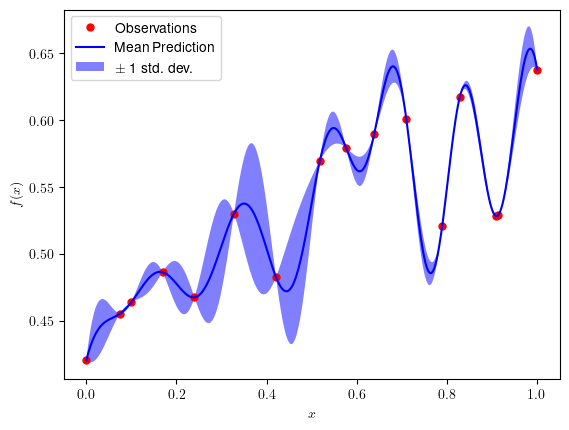

In [15]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

x2 = np.linspace(0, 1, 400)[:, None]
mu_pred, sigma_pred = bo_opt.model.predict(x2, return_std=True)

plt.plot(bo_opt.obs_x, bo_opt.obs_y, 'r.', markersize=10, label='Observations')
plt.plot(x2, mu_pred, 'b-', label=u'Mean Prediction')
plt.fill(np.concatenate([x2, x2[::-1]]),
        np.concatenate([mu_pred -  sigma_pred,
                    (mu_pred +  sigma_pred)[::-1]]),
        alpha=.5, fc='b', ec='None', label='$\pm$ 1 std. dev.')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper left')
plt.show()